In [694]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm,skew
from scipy import stats
from math import ceil
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from nltk import edit_distance
from sklearn.metrics import jaccard_score
from collections import Counter
import nltk
from nltk.util import bigrams
from nltk.cluster.util import cosine_distance
import networkx as nx
import os
import speech_recognition as sr
import ffmpeg
import subprocess
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import re
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
#nltk.download('wordnet') 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.metrics.distance import jaccard_distance
%matplotlib inline

In [798]:
# Reading LinkedIn connections csv file
# Training Dataset:- Connections.csv
# Test Dataset:- linkedin_data_new.csv
df = pd.read_csv('Connections.csv')

In [799]:
df.head()

,First_Name,Last_Name,No_of_Companies_Worked_for,Current_Company,Position,Connected_On
0,Umakanth,Vemula,1,EGEN Solutions Inc.,IT Technical Recruiter,20-Feb-20
1,DEEKSHA,NARAYAN,4,Clemson University Industrial Assessment Cente...,Graduate Student Intern,18-Feb-20
2,Sri,Sridharan,2,Clemson University,Professor,18-Feb-20
3,Brian,Innes,2,IBM,Watson IoT Developer Advocate,17-Feb-20
4,Joel Kiran,Kumar,3,Shubh Loans,Full-stack Developer,16-Feb-20


In [800]:
df.shape

(598, 6)

In [801]:
df.columns

Index(['First_Name', 'Last_Name', 'No_of_Companies_Worked_for',
       'Current_Company', 'Position', 'Connected_On'],
      dtype='object')

In [802]:
df.dtypes

First_Name                    object
Last_Name                     object
No_of_Companies_Worked_for     int64
Current_Company               object
Position                      object
Connected_On                  object
dtype: object

In [803]:
#Categorical Data
df.describe(include=['O'])

,First_Name,Last_Name,Current_Company,Position,Connected_On
count,586,586,565,565,598
unique,514,485,379,385,369
top,Vishal,Kumar,Clemson University,Technical Recruiter,23-Oct-19
freq,5,11,22,19,18


In [804]:
# Identifying number of NULL records which has to be removed.
total = df.isnull().sum().sort_values(ascending=False)

In [805]:
total

Position                      33
Current_Company               33
Last_Name                     12
First_Name                    12
Connected_On                   0
No_of_Companies_Worked_for     0
dtype: int64

In [703]:
df_new=df.dropna().copy()

In [704]:
# Cehcking the number of nulls after dropping the records
total = df_new.isnull().sum().sort_values(ascending=False)

In [705]:
total

Connected_On                  0
Position                      0
Current_Company               0
No_of_Companies_Worked_for    0
Last_Name                     0
First_Name                    0
dtype: int64

In [706]:
df_new

,First_Name,Last_Name,No_of_Companies_Worked_for,Current_Company,Position,Connected_On
0,Umakanth,Vemula,1,EGEN Solutions Inc.,IT Technical Recruiter,20-Feb-20
1,DEEKSHA,NARAYAN,4,Clemson University Industrial Assessment Cente...,Graduate Student Intern,18-Feb-20
2,Sri,Sridharan,2,Clemson University,Professor,18-Feb-20
3,Brian,Innes,2,IBM,Watson IoT Developer Advocate,17-Feb-20
4,Joel Kiran,Kumar,3,Shubh Loans,Full-stack Developer,16-Feb-20
...,...,...,...,...,...,...
593,Tarique,Shamim,2,Jio,Application Development Analyst,9-Nov-15
594,Saurabh,Pawar,3,OnMobile Global Limited,Software Engineer,9-Nov-15
595,Dinesh,Harsora,5,Alerteye digital surveillance solutions,Director,9-Nov-15
596,Ajinkya,Babar,4,Senate Systems Pvt. Ltd.,SAP MM FUNCTIONAL CONSULTANT,9-Jan-14


In [707]:
# Here, we're simply handling some
# commonly known abbreviations, stripping off common suffixes, 
# etc.
#df_new.loc['Current_Company'].replace(regex=', Inc$', value='', inplace=True)
df_new.replace({'Current_Company': r', Inc$'}, {'Current_Company': ''}, regex=True, inplace=True)
df_new.replace({'Current_Company': r' Inc.$'}, {'Current_Company': ''}, regex=True, inplace=True)
df_new.replace({'Current_Company': r' Pvt.$'}, {'Current_Company': ''}, regex=True, inplace=True)
df_new.replace({'Current_Company': r' Ltd.$'}, {'Current_Company': ''}, regex=True, inplace=True)
df_new.replace({'Current_Company': r' Pvt. Ltd.$'}, {'Current_Company': ''}, regex=True, inplace=True)
df_new.replace({'Current_Company': r' LLP$'}, {'Current_Company': ''}, regex=True, inplace=True)
df_new.replace({'Current_Company': r' LLC$'}, {'Current_Company': ''}, regex=True, inplace=True)

In [708]:
df_company=df_new['Current_Company'].value_counts().head(10)

In [709]:
df_company=pd.DataFrame({'Company':df_company.index, 'count':df_company.values})

In [710]:
df_company

,Company,count
0,Clemson University,22
1,Citi,14
2,JPMorgan Chase & Co.,12
3,Capgemini,11
4,Cognizant,9
5,Tata Consultancy Services,8
6,Barclays,8
7,Vodafone,8
8,Amazon,7
9,Accenture,7


In [711]:
df_company_top=df_new[df_new['Current_Company'].isin(['Clemson University', 'Citi', 'JPMorgan Chase & Co.','Capgemini','Cognizant'])]

In [712]:
df_company_top

,First_Name,Last_Name,No_of_Companies_Worked_for,Current_Company,Position,Connected_On
2,Sri,Sridharan,2,Clemson University,Professor,18-Feb-20
5,Sahar,Mihandoust,5,Clemson University,Research Assistant Professor,15-Feb-20
7,Srivathsan,Mohan,4,Clemson University,Student,14-Feb-20
23,Rutuja,Kulkarni,5,Clemson University,Student Assistant,31-Jan-20
25,Mary,Varughese,2,Clemson University,Supplemental Instructor,20-Jan-20
...,...,...,...,...,...,...
559,Shankaran,Krishnamurthi,2,Citi,Vice President,26-Sep-16
560,Vijay kumar,Koppala,3,Cognizant,Abinitio developer,26-Sep-16
573,Amit Shyam,Mahajan,2,Citi,AVP,1-Sep-16
585,Vikram Singh,Bhati,2,JPMorgan Chase & Co.,Application Developer,9-Nov-15


In [713]:
df_new['Position'].replace(['Sr.', 'Sr', 'Jr.', 'Jr', 'CEO', 'COO', 'CTO', 'CFO', 'VP'], 
                        ['Senior', 'Senior', 'Junior', 'Junior', 'Chief Executive Officer', 'Chief Operating Officer', 'Chief Technology Officer','Chief Finance Officer', 'Vice President'], inplace=True)

In [714]:
df_position=df_new['Position'].value_counts().head(10)

In [715]:
df_position=pd.DataFrame({'Position':df_position.index, 'count':df_position.values})

In [716]:
df_position

,Position,count
0,Technical Recruiter,19
1,Software Engineer,15
2,Consultant,15
3,Associate,11
4,Senior Software Engineer,9
5,Graduate Research Assistant,7
6,Senior Recruiter,6
7,Talent Acquisition Specialist,6
8,Senior Technical Recruiter,6
9,Assistant Manager,5


In [717]:
df_position_top=df_new[df_new['Position'].isin(['Technical Recruiter', 'Consultant', 'Software Engineer','Associate','Senior Software Engineer'])]

In [718]:
df_position_top

,First_Name,Last_Name,No_of_Companies_Worked_for,Current_Company,Position,Connected_On
8,Harshad,Salaskar,1,Deloitte,Consultant,14-Feb-20
33,Narsi,A,3,Infosys,Consultant,13-Jan-20
39,Ketan,Miniyar,6,Intellect Design Arena Ltd,Consultant,8-Jan-20
49,Dipika,Ramachandran,5,Amazon Web Services (AWS),Technical Recruiter,13-Dec-19
54,Martin,Thrasher,2,Apple,Technical Recruiter,6-Dec-19
...,...,...,...,...,...,...
572,Nupur,Khera,6,Hexaware Technologies,Senior Software Engineer,1-Sep-16
588,sahadev,nawar,2,Capgemini,Consultant,9-Nov-15
591,Yogesh,Chaudhari,4,OneOrigin,Senior Software Engineer,9-Nov-15
592,Ashutosh,Aswale,2,Deloitte India (Offices of the US),Consultant,9-Nov-15


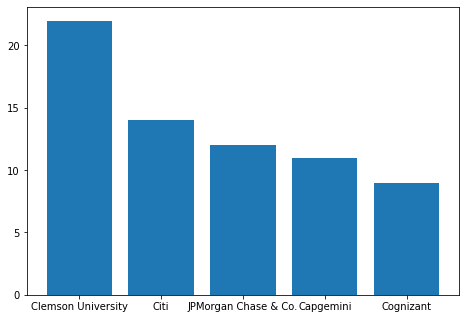

In [719]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_company['Company'].head(5),df_company['count'].head(5))
plt.show()

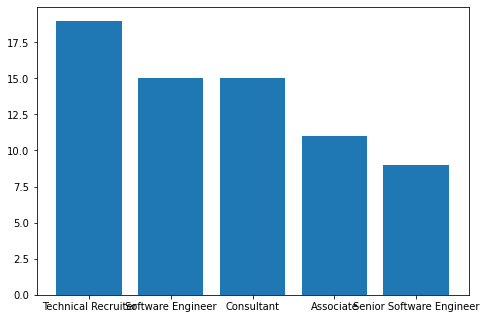

In [720]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(df_position['Position'].head(5),df_position['count'].head(5))
plt.show()

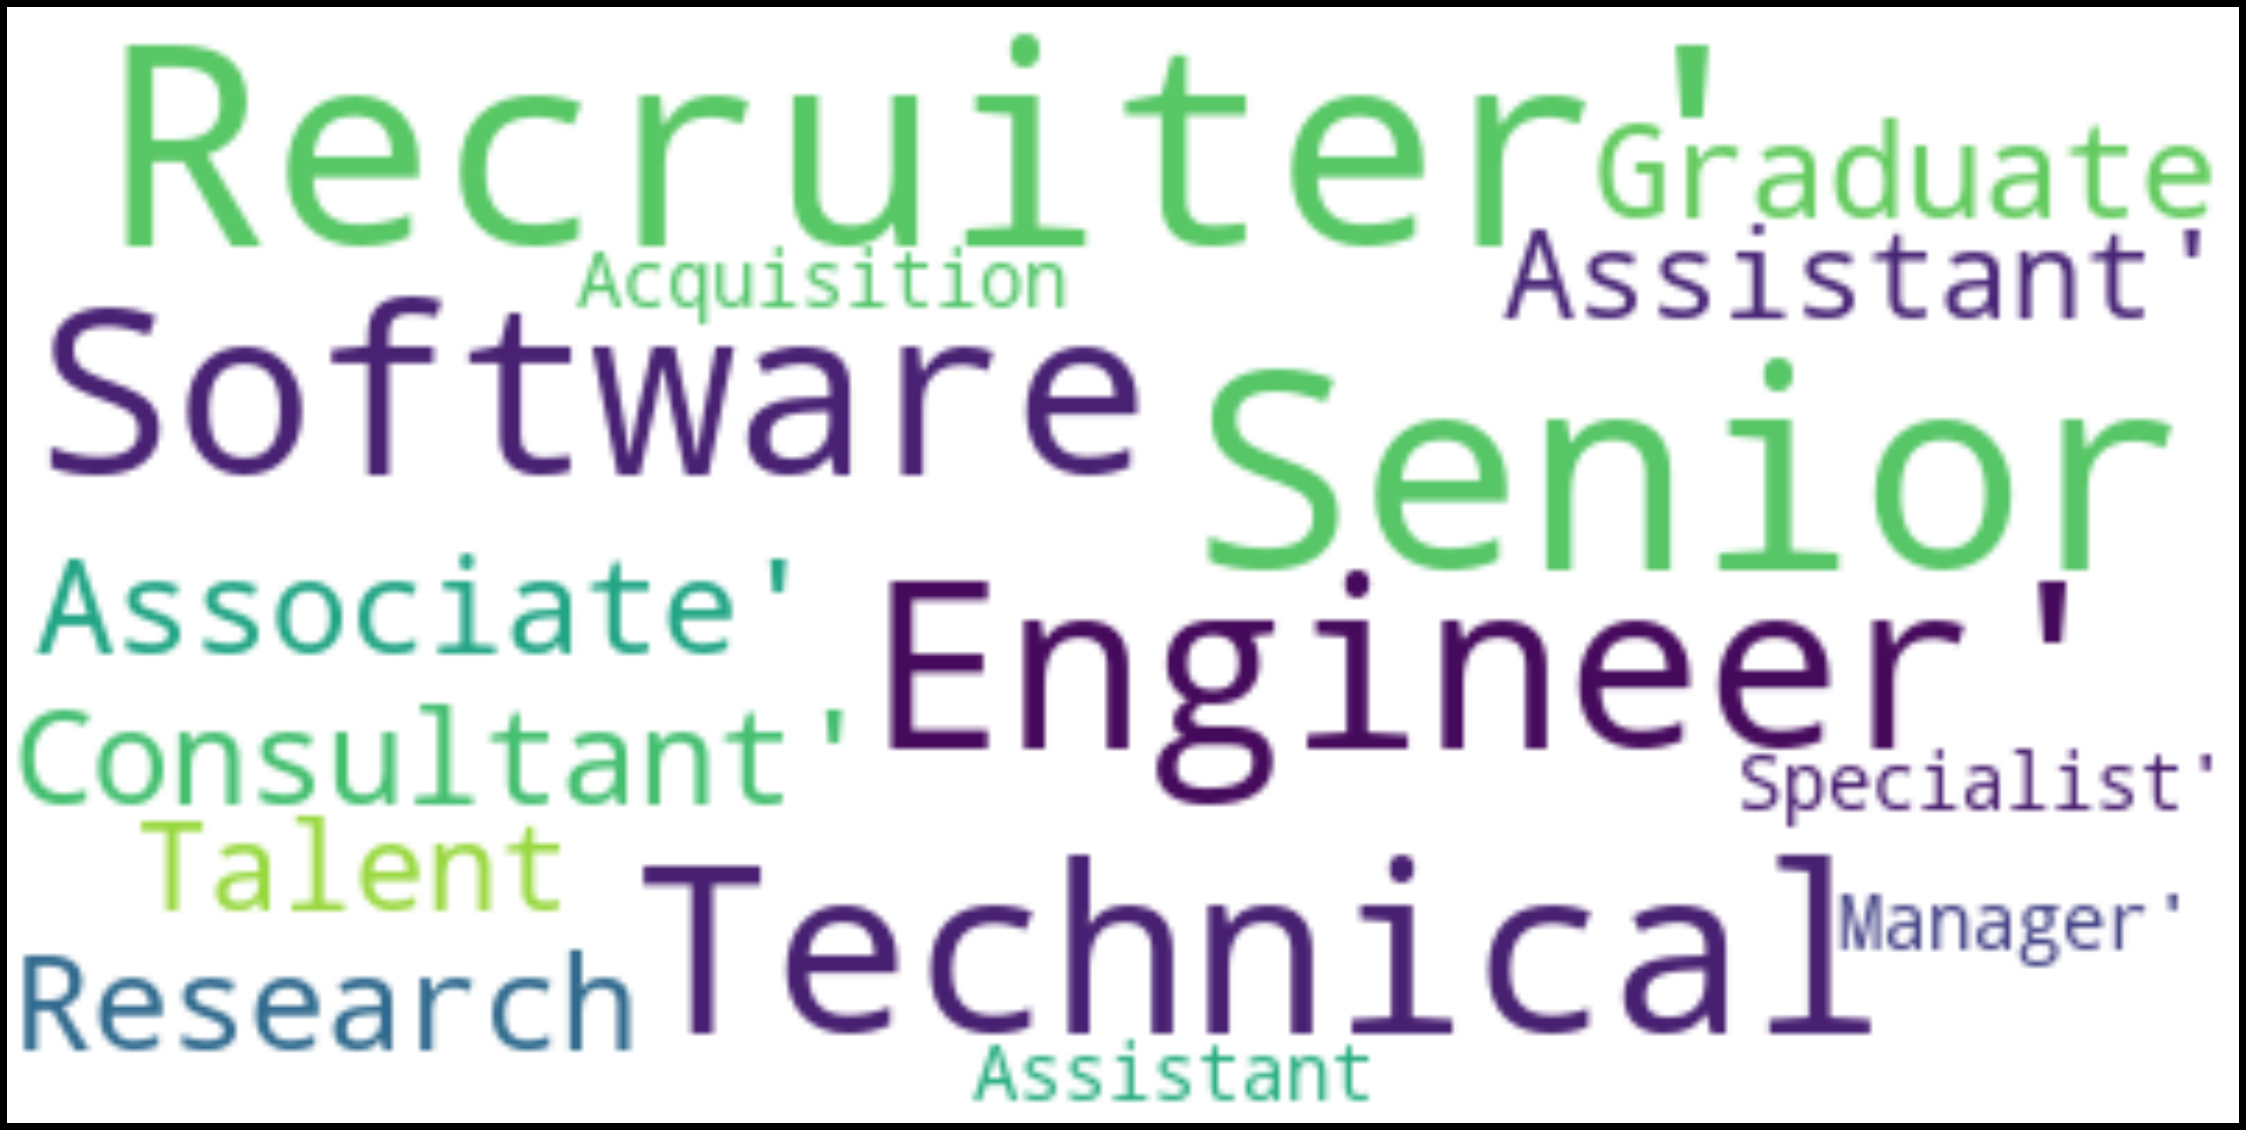

In [721]:
#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
text = df_position.Position.values
wordcloud = WordCloud(
                          background_color='white',
                          #stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(text))
print(wordcloud)
fig = plt.figure(figsize = (40,30), facecolor='k', edgecolor='k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()
fig.savefig("word1.png", dpi=900)

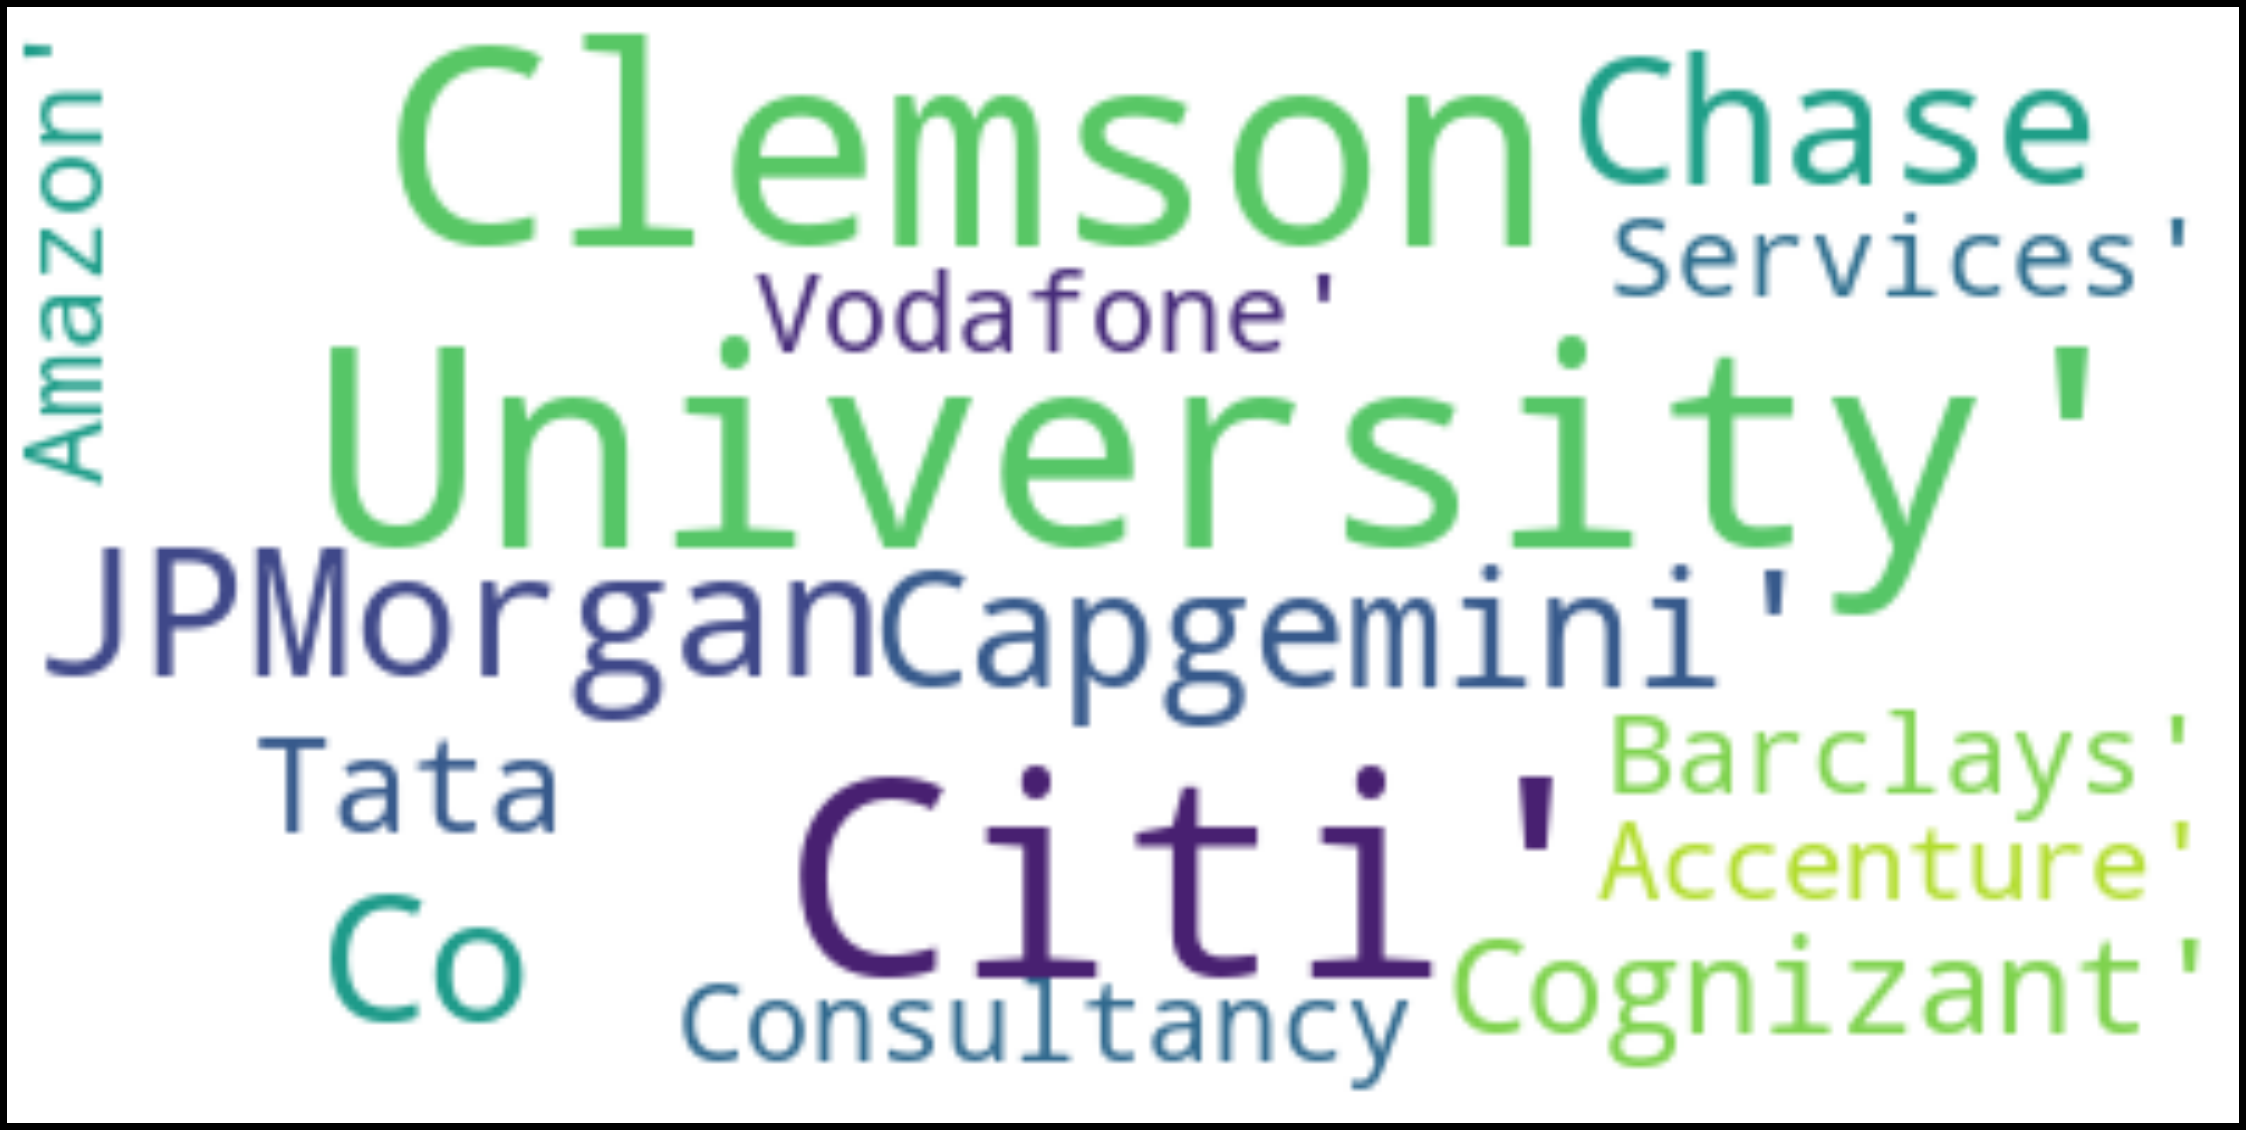

In [722]:
#Word cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
%matplotlib inline
text = df_company.Company.values
wordcloud = WordCloud(
                          background_color='white',
                          #stopwords=stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(text))
print(wordcloud)
fig = plt.figure(figsize = (40,30), facecolor='k', edgecolor='k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()
fig.savefig("word2.png", dpi=900)

In [723]:
#Similarity Computation using Edit Distance based on current company
import datetime
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
outputList = []
for rowRight in df_new.iterrows():
    for rowLeft in df_new.iterrows():
        if(rowRight[1][0]==rowLeft[1][0]):
            continue
        First_Person = rowRight[1][0]
        Second_Person = rowLeft[1][0]
        distance = edit_distance(rowRight[1][3],rowLeft[1][3])
        hostNames = rowRight[1][3] + "-" + rowLeft[1][3]
        outputList.append({"First_Person":First_Person, "Second_Person":Second_Person, "Distance":distance, "Company_Names":hostNames})

outputDf = pd.DataFrame(outputList)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))

Timestamp: 2020-04-19 18:49:45
Timestamp: 2020-04-19 18:51:49


In [724]:
outputDf.head(20)

,First_Person,Second_Person,Distance,Company_Names
0,Umakanth,DEEKSHA,50,EGEN Solutions -Clemson University Industrial ...
1,Umakanth,Sri,16,EGEN Solutions -Clemson University
2,Umakanth,Brian,15,EGEN Solutions -IBM
3,Umakanth,Joel Kiran,12,EGEN Solutions -Shubh Loans
4,Umakanth,Sahar,16,EGEN Solutions -Clemson University
5,Umakanth,Amit,14,EGEN Solutions -Oracle
6,Umakanth,Srivathsan,16,EGEN Solutions -Clemson University
7,Umakanth,Harshad,13,EGEN Solutions -Deloitte
8,Umakanth,Chris,14,EGEN Solutions -Sense Corp
9,Umakanth,Pearl,13,EGEN Solutions -FedEx Office


In [725]:
outputDf.sort_values(by=['Distance']).head(20)

,First_Person,Second_Person,Distance,Company_Names
148840,Rahul,Brian,0,IBM-IBM
256925,Anupama,Tejashree,0,JPMorgan Chase & Co.-JPMorgan Chase & Co.
256907,Anupama,Sagar,0,JPMorgan Chase & Co.-JPMorgan Chase & Co.
256902,Anupama,Rheya,0,JPMorgan Chase & Co.-JPMorgan Chase & Co.
256901,Anupama,Gayatri,0,JPMorgan Chase & Co.-JPMorgan Chase & Co.
256891,Anupama,Gauravski,0,JPMorgan Chase & Co.-JPMorgan Chase & Co.
256775,Anupama,Vijay,0,JPMorgan Chase & Co.-JPMorgan Chase & Co.
147946,Mahesh,Kedar,0,Cognizant-Cognizant
256715,Anupama,Arshis.,0,JPMorgan Chase & Co.-JPMorgan Chase & Co.
256714,Anupama,Alexandra,0,JPMorgan Chase & Co.-JPMorgan Chase & Co.


In [726]:
#Similarity Computation using Edit Distance based on job profile
outputList = []
for rowRight in df_new.iterrows():
    for rowLeft in df_new.iterrows():
        if(rowRight[1][0]==rowLeft[1][0]):
            continue
        First_Person = rowRight[1][0]
        Second_Person = rowLeft[1][0]
        distance = edit_distance(rowRight[1][4],rowLeft[1][4])
        hostNames = rowRight[1][4] + "-" + rowLeft[1][4]
        outputList.append({"First_Person":First_Person, "Second_Person":Second_Person, "Distance":distance, "Position":hostNames})

outputDf_pos = pd.DataFrame(outputList)

In [727]:
outputDf_pos.head(20)

,First_Person,Second_Person,Distance,Position
0,Umakanth,DEEKSHA,20,IT Technical Recruiter-Graduate Student Intern
1,Umakanth,Sri,20,IT Technical Recruiter-Professor
2,Umakanth,Brian,23,IT Technical Recruiter-Watson IoT Developer Ad...
3,Umakanth,Joel Kiran,17,IT Technical Recruiter-Full-stack Developer
4,Umakanth,Sahar,22,IT Technical Recruiter-Research Assistant Prof...
5,Umakanth,Amit,57,IT Technical Recruiter-Principal Consultant PE...
6,Umakanth,Srivathsan,19,IT Technical Recruiter-Student
7,Umakanth,Harshad,19,IT Technical Recruiter-Consultant
8,Umakanth,Chris,38,IT Technical Recruiter-Senior Data Warehouse A...
9,Umakanth,Pearl,12,IT Technical Recruiter-Sr. Recruiter


In [728]:
outputDf_pos.sort_values(by=['Distance']).head(20)

,First_Person,Second_Person,Distance,Position
27283,Erik,Deeksha,0,Associate Consultant-Associate Consultant
99520,Cristina,Shashi,0,Technical Recruiter-Technical Recruiter
99530,Cristina,Venkatesh,0,Technical Recruiter-Technical Recruiter
315146,Ashutosh,Ketan,0,Consultant-Consultant
153037,Nilesh,Anirban,0,Software Developer-Software Developer
58256,Kevin,Rahul,0,Senior Recruiter-Senior Recruiter
21804,Ketan,Priyanka,0,Consultant-Consultant
180391,Rama Krishna,Tarique,0,Application Development Analyst-Application De...
315140,Ashutosh,Narsi,0,Consultant-Consultant
18614,Melynda,Pearl,0,Sr. Recruiter-Sr. Recruiter


In [729]:
#Similarity Computation using Jaccard Score based on current company
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
outputList = []
for rowRight in df_new.iterrows():
    for rowLeft in df_new.iterrows():
        if(rowRight[1][0]==rowLeft[1][0]):
            continue
        First_Person = rowRight[1][0]
        Second_Person = rowLeft[1][0]
        a= set(rowRight[1][3])
        b= set(rowLeft[1][3])
        similarity = len(a.intersection(b))/len(a.union(b))
        distance = 1-similarity
        hostNames = rowRight[1][3] + "-" + rowLeft[1][3]
        outputList.append({"First_Person":First_Person, "Second_Person":Second_Person, "Similarity":similarity, "Distance":distance, "Company_Names":hostNames})

outputDf_company_jaccard = pd.DataFrame(outputList)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))

Timestamp: 2020-04-19 18:55:29
Timestamp: 2020-04-19 18:56:15


In [730]:
outputDf_company_jaccard.head(20)

,First_Person,Second_Person,Similarity,Distance,Company_Names
0,Umakanth,DEEKSHA,0.307692,0.692308,EGEN Solutions -Clemson University Industrial ...
1,Umakanth,Sri,0.368421,0.631579,EGEN Solutions -Clemson University
2,Umakanth,Brian,0.000000,1.000000,EGEN Solutions -IBM
3,Umakanth,Joel Kiran,0.375000,0.625000,EGEN Solutions -Shubh Loans
4,Umakanth,Sahar,0.368421,0.631579,EGEN Solutions -Clemson University
5,Umakanth,Amit,0.058824,0.941176,EGEN Solutions -Oracle
6,Umakanth,Srivathsan,0.368421,0.631579,EGEN Solutions -Clemson University
7,Umakanth,Harshad,0.285714,0.714286,EGEN Solutions -Deloitte
8,Umakanth,Chris,0.312500,0.687500,EGEN Solutions -Sense Corp
9,Umakanth,Pearl,0.157895,0.842105,EGEN Solutions -FedEx Office


In [731]:
outputDf_company_jaccard.sort_values(by=['Distance']).head(20)

,First_Person,Second_Person,Similarity,Distance,Company_Names
256978,Anupama,Subhashree,1.0,0.0,JPMorgan Chase & Co.-JPMorgan Chase & Co.
289382,Amit,Namrata,1.0,0.0,Syntel-Syntel
207154,Karthik,Mahesh,1.0,0.0,Cognizant-Cognizant
207129,Karthik,Kedar,1.0,0.0,Cognizant-Cognizant
60045,Archana,Gourav,1.0,0.0,Rang Technologies Inc-Rang Technologies Inc
178291,Megh,Camille,1.0,0.0,Facebook-Facebook
84668,Camille,Riky,1.0,0.0,Facebook-Facebook
178241,Megh,Riky,1.0,0.0,Facebook-Facebook
136579,Ishita,Akshay,1.0,0.0,Tata Consultancy Services-Tata Consultancy Ser...
114028,Nitesh,Akshay,1.0,0.0,Tata Consultancy Services-Tata Consultancy Ser...


In [732]:
#Similarity Computation using Jaccard Score based on job profile
outputList = []
for rowRight in df_new.iterrows():
    for rowLeft in df_new.iterrows():
        if(rowRight[1][0]==rowLeft[1][0]):
            continue
        First_Person = rowRight[1][0]
        Second_Person = rowLeft[1][0]
        a= set(rowRight[1][4])
        b= set(rowLeft[1][4])
        similarity = len(a.intersection(b))/len(a.union(b))
        distance = 1-similarity
        hostNames = rowRight[1][4] + "-" + rowLeft[1][4]
        outputList.append({"First_Person":First_Person, "Second_Person":Second_Person, "Similarity": similarity, "Distance":distance, "Position":hostNames})

outputDf_pos_jaccard = pd.DataFrame(outputList)

In [733]:
outputDf_pos_jaccard.head(20)

,First_Person,Second_Person,Similarity,Distance,Position
0,Umakanth,DEEKSHA,0.470588,0.529412,IT Technical Recruiter-Graduate Student Intern
1,Umakanth,Sri,0.111111,0.888889,IT Technical Recruiter-Professor
2,Umakanth,Brian,0.454545,0.545455,IT Technical Recruiter-Watson IoT Developer Ad...
3,Umakanth,Joel Kiran,0.363636,0.636364,IT Technical Recruiter-Full-stack Developer
4,Umakanth,Sahar,0.526316,0.473684,IT Technical Recruiter-Research Assistant Prof...
5,Umakanth,Amit,0.400000,0.600000,IT Technical Recruiter-Principal Consultant PE...
6,Umakanth,Srivathsan,0.250000,0.750000,IT Technical Recruiter-Student
7,Umakanth,Harshad,0.294118,0.705882,IT Technical Recruiter-Consultant
8,Umakanth,Chris,0.434783,0.565217,IT Technical Recruiter-Senior Data Warehouse A...
9,Umakanth,Pearl,0.500000,0.500000,IT Technical Recruiter-Sr. Recruiter


In [734]:
outputDf_pos_jaccard.sort_values(by=['Similarity'], ascending=False).head(20)

,First_Person,Second_Person,Similarity,Distance,Position
23252,M. Z.,kahkashan,1.0,0.0,Assistant Professor-Assistant Professor
47579,Abhinav,Rupali,1.0,0.0,Deputy Manager-Deputy Manager
177917,Chandra,RAM,1.0,0.0,Senior Software Engineer-Software Engineer
141577,mayur,Nikhil,1.0,0.0,Senior Software Engineer-Senior Software Engineer
170742,gurdeep,Neha,1.0,0.0,Lead Engineer-Lead Engineer
218627,Kalpesh,Debashis,1.0,0.0,Associate-Associate
110967,Namrata,Jayesh,1.0,0.0,Consultant-Consultant
164302,Carlo,Brittany,1.0,0.0,Senior Recruiter-Senior Recruiter
304696,Nupur,Raj,1.0,0.0,Senior Software Engineer-Software Engineer
4829,Harshad,CHAVI,1.0,0.0,Consultant-Consultant


In [735]:
#Similarity Computation using NGram based on current company
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
from ngram import NGram
outputList = []
for rowRight in df_new.iterrows():
    for rowLeft in df_new.iterrows():
        if(rowRight[1][0]==rowLeft[1][0]):
            continue
        First_Person = rowRight[1][0]
        Second_Person = rowLeft[1][0]
        similarity = NGram.compare(rowRight[1][3], rowLeft[1][3])
        hostNames = rowRight[1][3] + "-" + rowLeft[1][3]
        outputList.append({"First_Person":First_Person, "Second_Person":Second_Person, "Similarity": similarity,  "Company_Names":hostNames})

outputDf_comp_ngram = pd.DataFrame(outputList)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))

Timestamp: 2020-04-19 18:57:28
Timestamp: 2020-04-19 18:58:23


In [736]:
outputDf_comp_ngram.head(20)

,First_Person,Second_Person,Similarity,Company_Names
0,Umakanth,DEEKSHA,0.0,EGEN Solutions -Clemson University Industrial ...
1,Umakanth,Sri,0.0,EGEN Solutions -Clemson University
2,Umakanth,Brian,0.0,EGEN Solutions -IBM
3,Umakanth,Joel Kiran,0.0,EGEN Solutions -Shubh Loans
4,Umakanth,Sahar,0.0,EGEN Solutions -Clemson University
5,Umakanth,Amit,0.0,EGEN Solutions -Oracle
6,Umakanth,Srivathsan,0.0,EGEN Solutions -Clemson University
7,Umakanth,Harshad,0.0,EGEN Solutions -Deloitte
8,Umakanth,Chris,0.0,EGEN Solutions -Sense Corp
9,Umakanth,Pearl,0.0,EGEN Solutions -FedEx Office


In [737]:
outputDf_comp_ngram.sort_values(by=['Similarity'], ascending=False).head(20)

,First_Person,Second_Person,Similarity,Company_Names
77447,Tamanna,Akash,1.0,Clemson University-Clemson University
305299,Amit Shyam,Vishal.D,1.0,Citi-Citi
104488,Alyson,Christina,1.0,Amazon-Amazon
68808,Hong,Haley,1.0,Clemson University-Clemson University
279564,Mandeep,Shankaran,1.0,Citi-Citi
104492,Alyson,Amanda,1.0,Amazon-Amazon
155223,Ajinkya,Noah,1.0,Google-Google
83277,Sean,Darshan,1.0,Google-Google
24244,John,Brian,1.0,IBM-IBM
104487,Alyson,Anastasia,1.0,Amazon-Amazon


In [738]:
#Similarity Computation using NGram based on Job Profile
from ngram import NGram
outputList = []
for rowRight in df_new.iterrows():
    for rowLeft in df_new.iterrows():
        if(rowRight[1][0]==rowLeft[1][0]):
            continue
        First_Person = rowRight[1][0]
        Second_Person = rowLeft[1][0]
        similarity = NGram.compare(rowRight[1][4], rowLeft[1][4])
        hostNames = rowRight[1][4] + "-" + rowLeft[1][4]
        outputList.append({"First_Person":First_Person, "Second_Person":Second_Person, "Similarity": similarity,  "Position":hostNames})

outputDf_pos_ngram = pd.DataFrame(outputList)

In [739]:
outputDf_pos_ngram.head(20)

,First_Person,Second_Person,Similarity,Position
0,Umakanth,DEEKSHA,0.020833,IT Technical Recruiter-Graduate Student Intern
1,Umakanth,Sri,0.029412,IT Technical Recruiter-Professor
2,Umakanth,Brian,0.000000,IT Technical Recruiter-Watson IoT Developer Ad...
3,Umakanth,Joel Kiran,0.045455,IT Technical Recruiter-Full-stack Developer
4,Umakanth,Sahar,0.018868,IT Technical Recruiter-Research Assistant Prof...
5,Umakanth,Amit,0.010989,IT Technical Recruiter-Principal Consultant PE...
6,Umakanth,Srivathsan,0.000000,IT Technical Recruiter-Student
7,Umakanth,Harshad,0.000000,IT Technical Recruiter-Consultant
8,Umakanth,Chris,0.042857,IT Technical Recruiter-Senior Data Warehouse A...
9,Umakanth,Pearl,0.344828,IT Technical Recruiter-Sr. Recruiter


In [740]:
outputDf_pos_ngram.sort_values(by=['Similarity'], ascending=False).head(20)

,First_Person,Second_Person,Similarity,Position
148654,Souradip,Priyanka,1.0,Consultant-Consultant
235921,Ram Raghav,Shivani,1.0,ETL Developer-ETL Developer
21977,Ketan,sahadev,1.0,Consultant-Consultant
21905,Ketan,Miku,1.0,Consultant-Consultant
21890,Ketan,Jayesh,1.0,Consultant-Consultant
237144,CHIRAG,Sanjay,1.0,Managing Director-Managing Director
21827,Ketan,Rohan,1.0,Consultant-Consultant
21804,Ketan,Priyanka,1.0,Consultant-Consultant
292785,Harry,Alexandra,1.0,Vice President-Vice President
21746,Ketan,Prateek,1.0,Consultant-Consultant


In [741]:
#Similarity Computation using Cosine Distance based on job profile
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))
outputList = []
for rowRight in df_new.iterrows():
    for rowLeft in df_new.iterrows():
        if(rowRight[1][0]==rowLeft[1][0]):
            continue
        First_Person = rowRight[1][0]
        Second_Person = rowLeft[1][0]
        word1=[rowRight[1][4].lower()]
        word2=[rowLeft[1][4].lower()]
        all_words = list(set(word1 + word2))
        vector1 = [0] * len(all_words)
        vector2 = [0] * len(all_words)
        for w in word1:
            vector1[all_words.index(w)] += 1
        for w in word2:
            vector2[all_words.index(w)] += 1
        distance = cosine_distance(vector1,vector2)
        similarity = 1-distance
        hostNames = rowRight[1][4] + "-" + rowLeft[1][4]
        outputList.append({"First_Person":First_Person, "Second_Person":Second_Person, "Similarity": similarity, "Distance":distance, "Position":hostNames})

outputDf_cos_pos = pd.DataFrame(outputList)
print('Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now()))

Timestamp: 2020-04-19 18:59:53
Timestamp: 2020-04-19 19:00:46


In [742]:
outputDf_cos_pos.head(20)

,First_Person,Second_Person,Similarity,Distance,Position
0,Umakanth,DEEKSHA,0.0,1.0,IT Technical Recruiter-Graduate Student Intern
1,Umakanth,Sri,0.0,1.0,IT Technical Recruiter-Professor
2,Umakanth,Brian,0.0,1.0,IT Technical Recruiter-Watson IoT Developer Ad...
3,Umakanth,Joel Kiran,0.0,1.0,IT Technical Recruiter-Full-stack Developer
4,Umakanth,Sahar,0.0,1.0,IT Technical Recruiter-Research Assistant Prof...
5,Umakanth,Amit,0.0,1.0,IT Technical Recruiter-Principal Consultant PE...
6,Umakanth,Srivathsan,0.0,1.0,IT Technical Recruiter-Student
7,Umakanth,Harshad,0.0,1.0,IT Technical Recruiter-Consultant
8,Umakanth,Chris,0.0,1.0,IT Technical Recruiter-Senior Data Warehouse A...
9,Umakanth,Pearl,0.0,1.0,IT Technical Recruiter-Sr. Recruiter


In [743]:
outputDf_cos_pos.sort_values(by=['Similarity'], ascending=False).head(20)

,First_Person,Second_Person,Similarity,Distance,Position
263861,Jayesh,Ketan,1.0,0.0,Consultant-Consultant
302586,Arnab,Lalit,1.0,0.0,Tech Lead-Tech Lead
169014,Omkar,Rita,1.0,0.0,Application Developer-Application Developer
158384,Vijay,kavishi,1.0,0.0,Software Engineer-Software Engineer
180968,CHAVI,Harshad,1.0,0.0,Consultant-Consultant
227409,Ankita,Rajashekar,1.0,0.0,Project Manager-Project Manager
21618,Ketan,Namrata,1.0,0.0,Consultant-Consultant
165922,Shashi,Alicia,1.0,0.0,Technical Recruiter-Technical Recruiter
212248,Lokesh,Vijay,1.0,0.0,Software Engineer-Software Engineer
103476,Felix,Venkatesh,1.0,0.0,Technical Recruiter-Technical Recruiter


In [744]:
#Similarity Computation using Cosine Distance based on current company
outputList = []
for rowRight in df_new.iterrows():
    for rowLeft in df_new.iterrows():
        if(rowRight[1][0]==rowLeft[1][0]):
            continue
        First_Person = rowRight[1][0]
        Second_Person = rowLeft[1][0]
        word1=[rowRight[1][3].lower()]
        word2=[rowLeft[1][3].lower()]
        all_words = list(set(word1 + word2))
        vector1 = [0] * len(all_words)
        vector2 = [0] * len(all_words)
        for w in word1:
            vector1[all_words.index(w)] += 1
        for w in word2:
            vector2[all_words.index(w)] += 1
        distance = cosine_distance(vector1,vector2)
        similarity = 1-distance
        hostNames = rowRight[1][3] + "-" + rowLeft[1][3]
        outputList.append({"First_Person":First_Person, "Second_Person":Second_Person, "Similarity": similarity, "Distance":distance, "Company":hostNames})

outputDf_cos_comp = pd.DataFrame(outputList)

In [745]:
outputDf_cos_comp.head(20)

,First_Person,Second_Person,Similarity,Distance,Company
0,Umakanth,DEEKSHA,0.0,1.0,EGEN Solutions -Clemson University Industrial ...
1,Umakanth,Sri,0.0,1.0,EGEN Solutions -Clemson University
2,Umakanth,Brian,0.0,1.0,EGEN Solutions -IBM
3,Umakanth,Joel Kiran,0.0,1.0,EGEN Solutions -Shubh Loans
4,Umakanth,Sahar,0.0,1.0,EGEN Solutions -Clemson University
5,Umakanth,Amit,0.0,1.0,EGEN Solutions -Oracle
6,Umakanth,Srivathsan,0.0,1.0,EGEN Solutions -Clemson University
7,Umakanth,Harshad,0.0,1.0,EGEN Solutions -Deloitte
8,Umakanth,Chris,0.0,1.0,EGEN Solutions -Sense Corp
9,Umakanth,Pearl,0.0,1.0,EGEN Solutions -FedEx Office


In [746]:
outputDf_cos_comp.sort_values(by=['Similarity'], ascending=False).head(20)

,First_Person,Second_Person,Similarity,Distance,Company
93226,Madhur,Kashish,1.0,0.0,Clemson University-Clemson University
1283,Sri,Feng,1.0,0.0,Clemson University-Clemson University
29251,Sumit,Rita,1.0,0.0,Vodafone-Vodafone
115132,Kashish,Hong,1.0,0.0,Clemson University-Clemson University
140430,Ionut,Sumit,1.0,0.0,Vodafone-Vodafone
158398,Vijay,Vikram Singh,1.0,0.0,JPMorgan Chase & Co.-JPMorgan Chase & Co.
217592,Anu,Gaurav.D,1.0,0.0,Accenture-Accenture
1292,Sri,Madhur,1.0,0.0,Clemson University-Clemson University
104492,Alyson,Amanda,1.0,0.0,Amazon-Amazon
226256,Darshan,Noah,1.0,0.0,Google-Google


In [747]:
df_company_top_graph=df_new[df_new['Current_Company'].isin(['Clemson University', 'Citi', 'JPMorgan Chase & Co.','Capgemini','Cognizant','Vodafone','Barclays', 'Tata Consultancy Services', 'Amazon', 'Accenture'])]

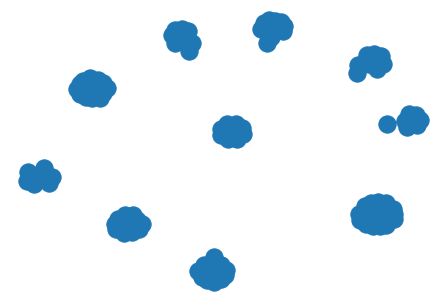

In [748]:
g = nx.from_pandas_edgelist(df_company_top_graph, source='First_Name', target='Current_Company') 
nx.draw(g)

In [749]:
#Let’s build a nice visualization
companies = list(df_company_top_graph.Current_Company.unique())

In [750]:
people = list(df_company_top_graph.First_Name.unique())

In [751]:
dict(zip(companies, companies))

{'Clemson University': 'Clemson University',
 'Amazon': 'Amazon',
 'Vodafone': 'Vodafone',
 'Accenture': 'Accenture',
 'Citi': 'Citi',
 'Tata Consultancy Services': 'Tata Consultancy Services',
 'JPMorgan Chase & Co.': 'JPMorgan Chase & Co.',
 'Cognizant': 'Cognizant',
 'Capgemini': 'Capgemini',
 'Barclays': 'Barclays'}

In [752]:
g.degree('Clemson University')

22

In [753]:
[company for company in companies]

['Clemson University',
 'Amazon',
 'Vodafone',
 'Accenture',
 'Citi',
 'Tata Consultancy Services',
 'JPMorgan Chase & Co.',
 'Cognizant',
 'Capgemini',
 'Barclays']

In [754]:
[g.degree(company) for company in companies]

[22, 6, 8, 7, 14, 8, 12, 9, 11, 8]

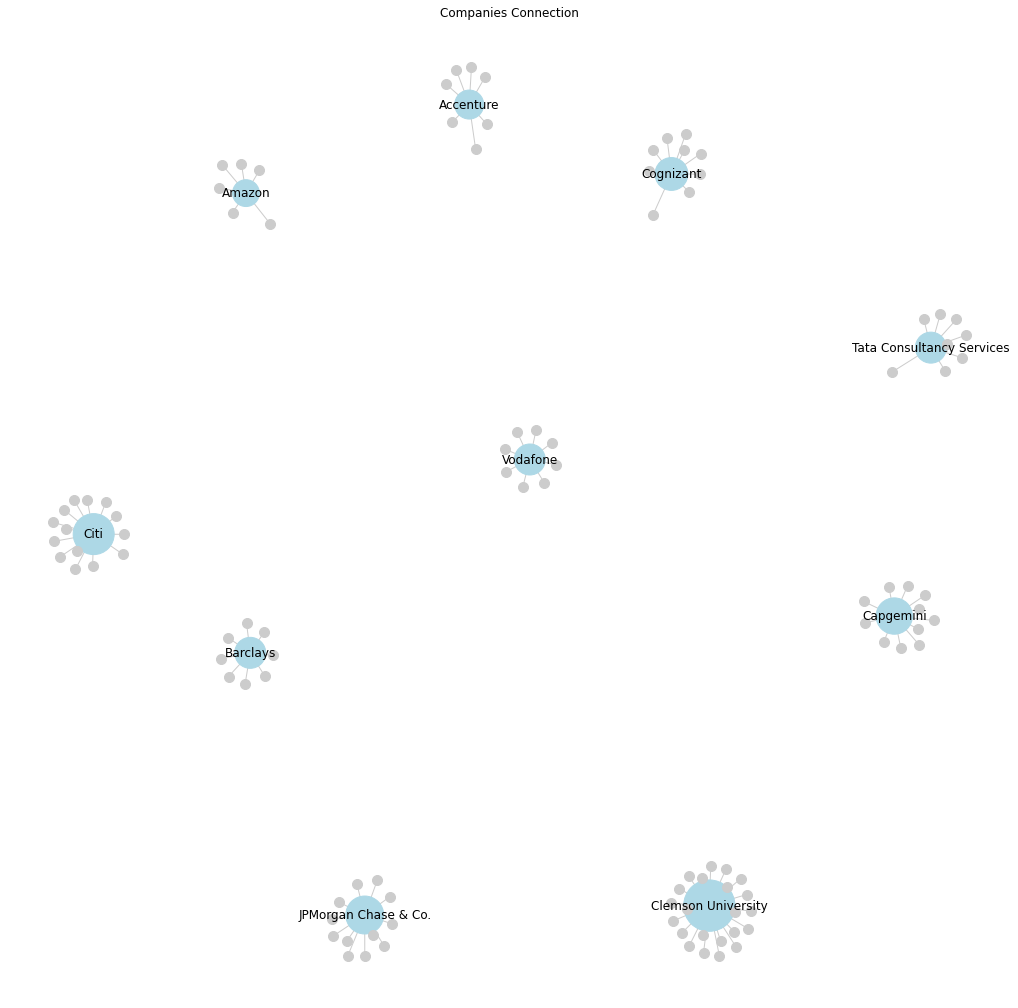

In [755]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 18))

# 1. Create the graph
g = nx.from_pandas_edgelist(df_company_top_graph, source='First_Name', target='Current_Company') 

# 2. Create a layout for our nodes 
layout = nx.spring_layout(g,iterations=50)


# 3. Go through every company, ask the graph how many
# connections it has. Multiply that by 120 to get the circle size
company_size = [g.degree(company) * 120 for company in companies]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=companies, 
                       node_size=company_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# 4. Draw EVERYONE
nx.draw_networkx_nodes(g, layout, nodelist=people, node_color='#cccccc', node_size=100)

# 5. Draw POPULAR PEOPLE
popular_people = [person for person in people if g.degree(person) > 1]
popular_people_label={}
for label in popular_people:
    popular_people_label[label]=label
    
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, labels=popular_people_label, node_color='orange', node_size=120)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(companies, companies))
node_labels_new = node_labels.update(popular_people_label)

nx.draw_networkx_labels(g, layout, labels=node_labels)

# 6. Turn off the axis
plt.axis('off')

plt.title("Companies Connection")

# 7. Plot using matplotlib
plt.show()

dict_values([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 0, 2, 0, 3, 3, 0, 0, 4, 4, 0, 0, 0, 0, 1, 5, 5, 0, 0, 0, 5, 1, 1, 1, 1, 5, 0, 0, 0, 6, 6, 6, 2, 2, 7, 7, 3, 5, 2, 5, 7, 8, 8, 9, 9, 6, 7, 8, 2, 8, 9, 7, 5, 4, 2, 7, 7, 3, 6, 8, 6, 6, 4, 6, 8, 6, 8, 4, 4, 8, 4, 8, 6, 3, 7, 9, 8, 5, 3, 9, 6, 6, 9, 4, 4, 8, 2, 7, 4, 4, 4, 4, 4, 7, 5, 9, 9, 4, 9, 6, 3, 8, 3])
115
10


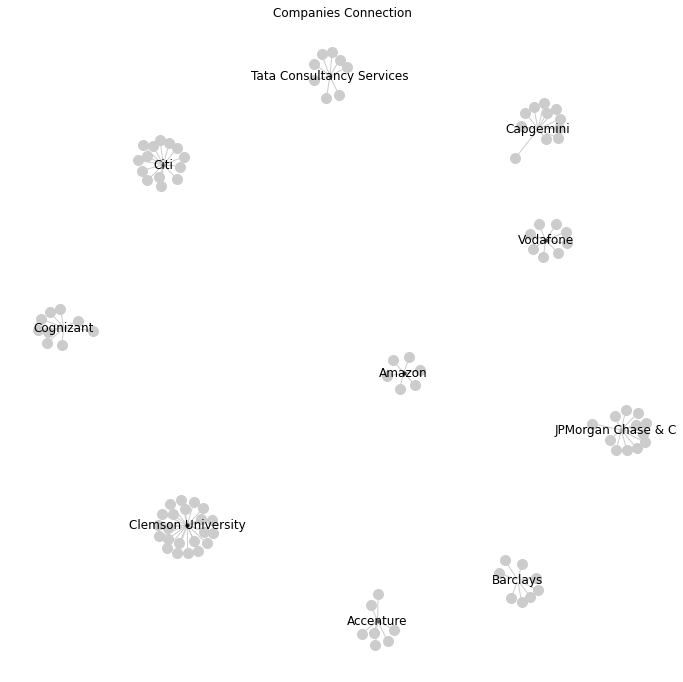

In [756]:
import community
import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

# 1. Create the graph
g = nx.from_pandas_edgelist(df_company_top_graph, source='First_Name', target='Current_Company') 

# Best partitioning calls out louvain Library in python
partition=community.best_partition(g)

# 2. Create a layout for our nodes 
layout = nx.spring_layout(g,iterations=50)


# 3. Go through every company, ask the graph how many
# connections it has. Multiply that by 120 to get the circle size
company_size = float(len(set(partition.values())))
print(partition.values())
print(len(partition.values()))
print(len(set(partition.values())))
count=0
for com in set(partition.values()) :
    count = count+1
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(g, 
                       layout, 
                       list_nodes, 
                       node_size=company_size, # a LIST of sizes, based on g.degree
                       node_color = str(count / company_size))

# 4. Draw EVERYONE
nx.draw_networkx_nodes(g, layout, nodelist=people, node_color='#cccccc', node_size=100)

# 5. Draw POPULAR PEOPLE
popular_people = [person for person in people if g.degree(person) > 1]
popular_people_label={}
for label in popular_people:
    popular_people_label[label]=label
#print(popular_people_label)
    
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, labels=popular_people_label, node_color='orange', node_size=120)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(companies, companies))
node_labels_new = node_labels.update(popular_people_label)

nx.draw_networkx_labels(g, layout, labels=node_labels)

# 6. Turn off the axis.
plt.axis('off')

plt.title("Companies Connection")

# 7. Plot the graph using matplotlib
plt.show()

In [757]:
df_position_top_graph=df_new[df_new['Position'].isin(['Technical Recruiter', 'Consultant', 'Software Engineer','Associate','Senior Software Engineer', 'Graduate Research Assistant', 'Senior Recruiter', 'Assistant Manager', 'Professor'])]

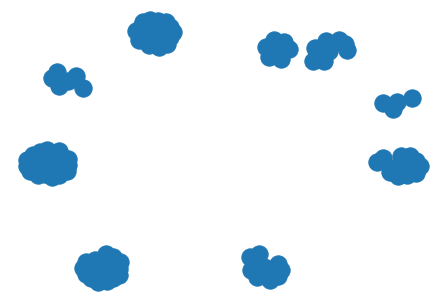

In [758]:
g = nx.from_pandas_edgelist(df_position_top_graph, source='First_Name', target='Position') 
nx.draw(g)

In [759]:
#Let’s build a nice visualization
Positions = list(df_position_top_graph.Position.unique())

In [760]:
people = list(df_position_top_graph.First_Name.unique())

In [761]:
dict(zip(Positions, Positions))

{'Professor': 'Professor',
 'Consultant': 'Consultant',
 'Graduate Research Assistant': 'Graduate Research Assistant',
 'Senior Recruiter': 'Senior Recruiter',
 'Technical Recruiter': 'Technical Recruiter',
 'Assistant Manager': 'Assistant Manager',
 'Senior Software Engineer': 'Senior Software Engineer',
 'Software Engineer': 'Software Engineer',
 'Associate': 'Associate'}

In [762]:
g.degree('Technical Recruiter')

19

In [763]:
[position for position in Positions]

['Professor',
 'Consultant',
 'Graduate Research Assistant',
 'Senior Recruiter',
 'Technical Recruiter',
 'Assistant Manager',
 'Senior Software Engineer',
 'Software Engineer',
 'Associate']

In [764]:
[g.degree(position) for position in Positions]

[3, 15, 7, 6, 19, 5, 9, 15, 11]

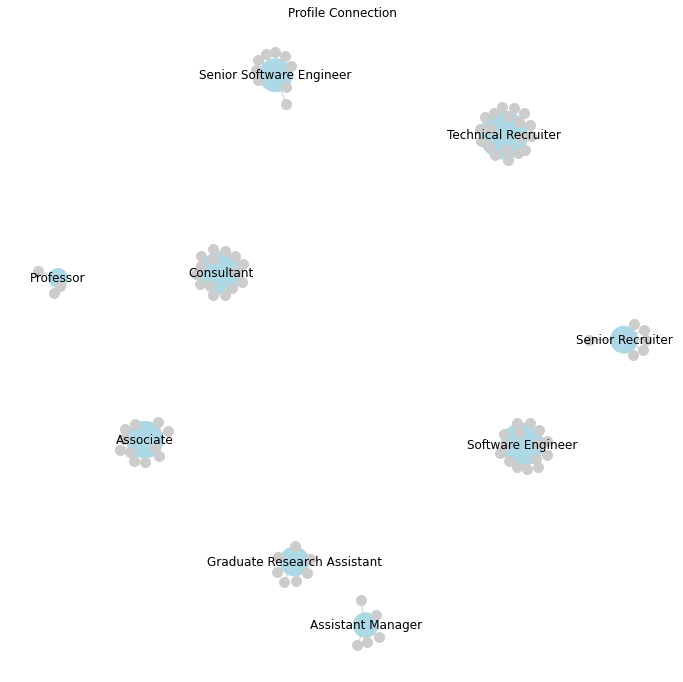

In [765]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))

# 1. Create the graph
g = nx.from_pandas_edgelist(df_position_top_graph, source='First_Name', target='Position') 

# 2. Create a layout for our nodes 
layout = nx.spring_layout(g,iterations=50)


# 3. Go through every Position name, ask the graph how many
# connections it has. Multiply that by 120 to get the circle size
company_size = [g.degree(position) * 120 for position in Positions]
nx.draw_networkx_nodes(g, 
                       layout, 
                       nodelist=Positions, 
                       node_size=company_size, # a LIST of sizes, based on g.degree
                       node_color='lightblue')

# 4. Draw EVERYONE
nx.draw_networkx_nodes(g, layout, nodelist=people, node_color='#cccccc', node_size=100)

# 5. Draw POPULAR PEOPLE
popular_people = [person for person in people if g.degree(person) > 1]
popular_people_label={}
for label in popular_people:
    popular_people_label[label]=label
    
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, labels=popular_people_label, node_color='orange', node_size=120)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(Positions, Positions))
node_labels_new = node_labels.update(popular_people_label)

nx.draw_networkx_labels(g, layout, labels=node_labels)

# 6. Turn off the axis
plt.axis('off')

plt.title("Profile Connection")

# 7. Plot the graph using matplotlib
plt.show()

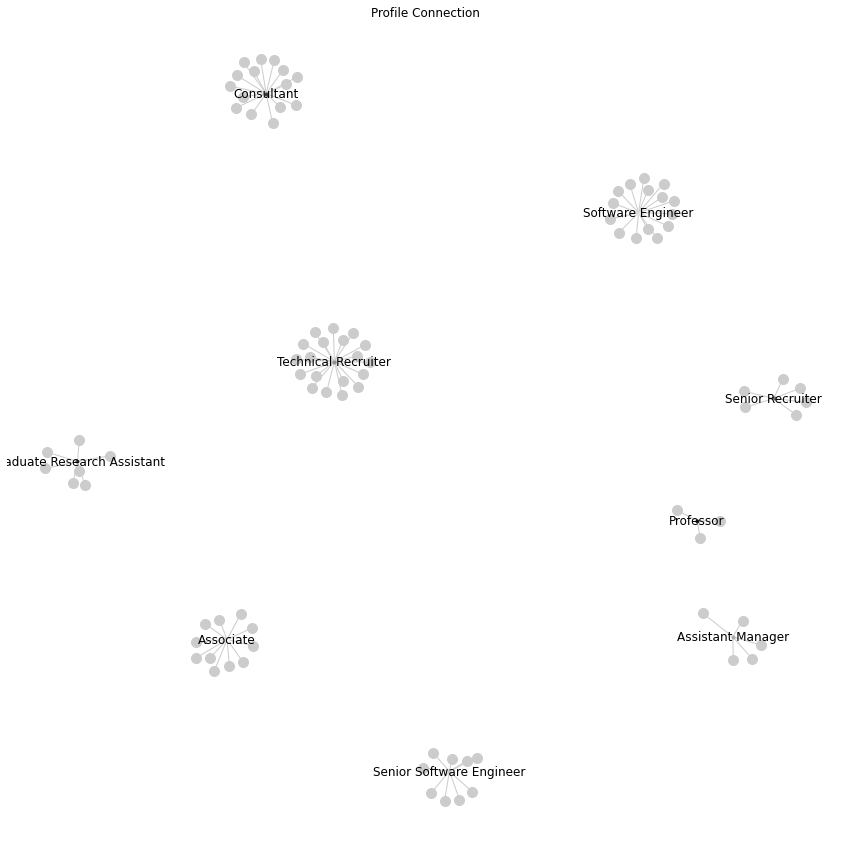

In [766]:
import community
import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

# 1. Create the graph
g = nx.from_pandas_edgelist(df_position_top_graph, source='First_Name', target='Position') 

partition=community.best_partition(g)

# 2. Create a layout for our nodes 
layout = nx.spring_layout(g,iterations=50)


# 3. Go through every Position, ask the graph how many
# connections it has. Multiply that by 120 to get the circle size
company_size = float(len(set(partition.values())))
count=0
for com in set(partition.values()) :
    count = count+1
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(g, 
                       layout, 
                       list_nodes, 
                       node_size=company_size, # a LIST of sizes, based on g.degree
                       node_color = str(count / company_size))

# 4. Draw EVERYONE
nx.draw_networkx_nodes(g, layout, nodelist=people, node_color='#cccccc', node_size=100)

# 5. Draw POPULAR PEOPLE
popular_people = [person for person in people if g.degree(person) > 1]
popular_people_label={}
for label in popular_people:
    popular_people_label[label]=label
#print(popular_people_label)
    
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, labels=popular_people_label, node_color='orange', node_size=120)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(Positions, Positions))
node_labels_new = node_labels.update(popular_people_label)

nx.draw_networkx_labels(g, layout, labels=node_labels)

# 6. Turn off the axis.
plt.axis('off')

plt.title("Profile Connection")

# 7. Plot the graph using matplotlib
plt.show()

In [767]:
# Reading LinkedIn connections csv file
df_skills = pd.read_csv('skills.csv')

In [768]:
#Let’s build a nice visualization
Skills = list(df_skills.Skills.unique())

In [769]:
people = list(df_skills.First_Name.unique())

In [770]:
people

['Mugdha',
 'Rutuja',
 'John',
 'Brian',
 'Nikhil',
 'Parth',
 'Tamanna',
 'Adithya',
 'Abhimanyu',
 'Mahesh',
 'Akash',
 'Diksha',
 'Rupali',
 'Chris']

In [771]:
dict(zip(Skills, Skills))

{'Java': 'Java',
 'Python': 'Python',
 'Machine Learning': 'Machine Learning',
 'IBM Watson': 'IBM Watson',
 'Data Engineering': 'Data Engineering',
 'AWS': 'AWS',
 'Data Science': 'Data Science'}

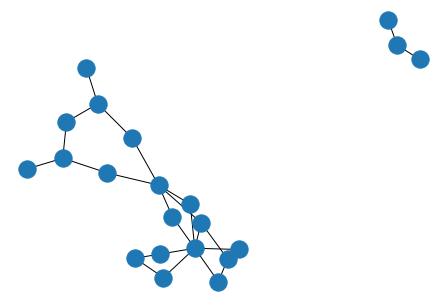

In [772]:
g = nx.from_pandas_edgelist(df_skills, source='First_Name', target='Skills') 
nx.draw(g)

In [773]:
g.degree('Python')

5

In [774]:
[skill for skill in Skills]

['Java',
 'Python',
 'Machine Learning',
 'IBM Watson',
 'Data Engineering',
 'AWS',
 'Data Science']

In [775]:
[g.degree(skill) for skill in Skills]

[7, 5, 3, 2, 3, 2, 3]

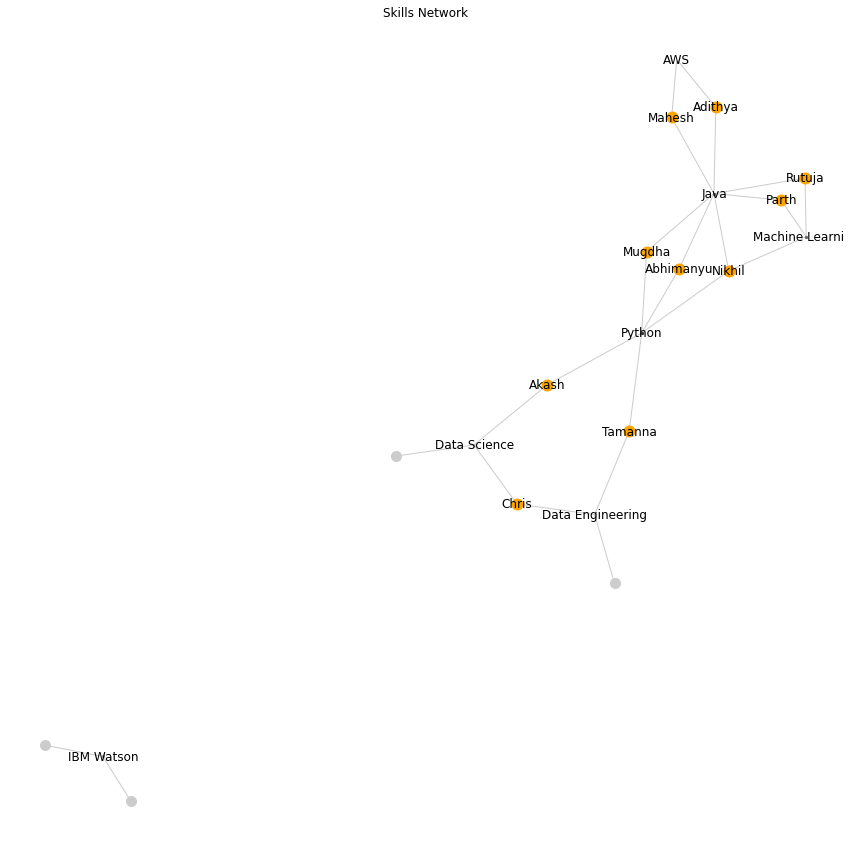

In [776]:
import community
import networkx as nx
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))

# 1. Create the graph
g = nx.from_pandas_edgelist(df_skills, source='First_Name', target='Skills') 

partition=community.best_partition(g)

# 2. Create a layout for our nodes 
layout = nx.spring_layout(g,iterations=50)


# 3. Go through every Skill, ask the graph how many
# connections it has. Multiply that by 120 to get the circle size
company_size = float(len(set(partition.values())))
count=0
for com in set(partition.values()) :
    count = count+1
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    nx.draw_networkx_nodes(g, 
                       layout, 
                       list_nodes, 
                       node_size=company_size, # a LIST of sizes, based on g.degree
                       node_color = str(count / company_size))

# 4. Draw EVERYONE
nx.draw_networkx_nodes(g, layout, nodelist=people, node_color='#cccccc', node_size=100)

# 5. Draw POPULAR PEOPLE
popular_people = [person for person in people if g.degree(person) > 1]
popular_people_label={}
for label in popular_people:
    popular_people_label[label]=label
#print(popular_people_label)
    
nx.draw_networkx_nodes(g, layout, nodelist=popular_people, labels=popular_people_label, node_color='orange', node_size=120)

nx.draw_networkx_edges(g, layout, width=1, edge_color="#cccccc")

node_labels = dict(zip(Skills, Skills))
node_labels_new = node_labels.update(popular_people_label)

nx.draw_networkx_labels(g, layout, labels=node_labels)

# 6. Turn off the axis.
plt.axis('off')

plt.title("Skills Network")

# 7. Plot the graph using matplotlib
plt.show()

In [777]:
#Greedy Heuristic
DISTANCE_THRESHOLD = 0.6
DISTANCE = jaccard_distance


def cluster_contacts_by_title():
    
    all_titles = []
    for rowRight in df_new[:200].iterrows():
        if(rowRight[1][4] in all_titles): 
            continue
        titles = rowRight[1][4]
        
        all_titles.append(titles)

    all_titles = list(set(all_titles))

    clusters = {}
    for title1 in all_titles:
        clusters[title1] = []
        for title2 in all_titles:
            if title2 in clusters[title1] or title2 in clusters and title1 \
                in clusters[title2]:
                continue
            try:
                distance = DISTANCE(set(title1.split()), set(title2.split()))
            except:
                print(title1.split())
                print(title2.split())
                continue

            if distance < DISTANCE_THRESHOLD:
                clusters[title1].append(title2)

    # Flatten out clusters
    clusters = [clusters[title] for title in clusters] #if len(clusters[title]) > 1]

    # Round up contacts who are in these clusters and group them together
    clustered_contacts = {}
    for cluster in clusters:
        clustered_contacts[tuple(cluster)] = []
        for label, contact in contacts.iterrows():
            title=contact['Position']
            first_name=contact['First_Name']
            last_name=contact['Last_Name']
            if title in cluster:
                clustered_contacts[tuple(cluster)].append('{0} {1}.'.format(first_name, last_name))

    return clustered_contacts


clustered_contacts = cluster_contacts_by_title()


for titles in clustered_contacts:
    common_titles_heading = 'Common Titles: ' + ', '.join(titles)

    descriptive_terms = set(titles[0].split())
    for title in titles:
        descriptive_terms.intersection_update(set(title.split()))
    if len(descriptive_terms) == 0: descriptive_terms = ['***No words in common***']
    descriptive_terms_heading = 'Descriptive Terms: ' \
        + ', '.join(descriptive_terms)
    print('\n'+common_titles_heading)
    print(descriptive_terms_heading)
    print('-' * 70)
    print('\n'.join(clustered_contacts[titles]))
    print('-' * 70)


Common Titles: Software Engineer, Senior Software Engineer, Freelance Software Engineer, Software Development Engineer
Descriptive Terms: Engineer, Software
----------------------------------------------------------------------
Aarav Chandra.
Nikhil Khaladkar.
Aarti Barai.
Mahesh Magai.
----------------------------------------------------------------------

Common Titles: Recruiter - Data Science, Data Science and Analytics Recruiter, Data Science Recruiter, Talent Acquisition Manager - Data Science, Data Science and Data Analytics Recruiter
Descriptive Terms: Data, Science
----------------------------------------------------------------------
Jeff Resta.
Riky Segal Williams.
Raja Vishwakarma.
Tanmay Sharma.
James Gannon.
----------------------------------------------------------------------

Common Titles: Lead Technical Recruiter, Senior Technical Recruiter, Technical Recruiter, IT Technical Recruiter, Technical Lead
Descriptive Terms: Technical
-------------------------------------

In [778]:
#Greedy Heuristic
DISTANCE_THRESHOLD = 0.6
DISTANCE = jaccard_distance

contacts = df[:200]
def cluster_contacts_by_title():

    all_titles = []
    for rowRight in df_new.iterrows():
        if(rowRight[1][3] in all_titles): 
            continue
        titles = rowRight[1][3]
        
        all_titles.append(titles)

    all_titles = list(set(all_titles))

    clusters = {}
    for title1 in all_titles:
        clusters[title1] = []
        for title2 in all_titles:
            if title2 in clusters[title1] or title2 in clusters and title1 \
                in clusters[title2]:
                continue
            try:
                distance = DISTANCE(set(title1.split()), set(title2.split()))
            except:
                print(title1.split())
                print(title2.split())
                continue

            if distance < DISTANCE_THRESHOLD:
                clusters[title1].append(title2)

    # Flatten out clusters
    clusters = [clusters[title] for title in clusters] #if len(clusters[title]) > 1]

    # Round up contacts who are in these clusters and group them together
    clustered_contacts = {}
    for cluster in clusters:
        clustered_contacts[tuple(cluster)] = []
        for label, contact in contacts.iterrows():
            title=contact['Current_Company']
            first_name=contact['First_Name']
            last_name=contact['Last_Name']
            if title in cluster:
                clustered_contacts[tuple(cluster)].append('{0} {1}.'.format(first_name, last_name))

    return clustered_contacts


clustered_contacts = cluster_contacts_by_title()

for titles in clustered_contacts:
    common_titles_heading = 'Common Titles: ' + ', '.join(titles)

    descriptive_terms = set(titles[0].split())
    for title in titles:
        descriptive_terms.intersection_update(set(title.split()))
    if len(descriptive_terms) == 0: descriptive_terms = ['***No words in common***']
    descriptive_terms_heading = 'Descriptive Terms: ' \
        + ', '.join(descriptive_terms)
    print('\n'+common_titles_heading)
    print(descriptive_terms_heading)
    print('-' * 70)
    print('\n'.join(clustered_contacts[titles]))
    print('-' * 70)


Common Titles: Astra Microwave Products Ltd
Descriptive Terms: Astra, Ltd, Products, Microwave
----------------------------------------------------------------------

----------------------------------------------------------------------

Common Titles: Maveric Systems Limited
Descriptive Terms: Maveric, Systems, Limited
----------------------------------------------------------------------

----------------------------------------------------------------------

Common Titles: EGEN Solutions 
Descriptive Terms: EGEN, Solutions
----------------------------------------------------------------------

----------------------------------------------------------------------

Common Titles: Wipro Limited, Wipro
Descriptive Terms: Wipro
----------------------------------------------------------------------

----------------------------------------------------------------------

Common Titles: Global Touchpoints
Descriptive Terms: Global, Touchpoints
--------------------------------------------

In [779]:
#Hierarchical Clustering
import nltk
nltk.download('stopwords')
from nltk.metrics.distance import jaccard_distance
from nltk.corpus import stopwords # nltk.download('stopwords')
from cluster import HierarchicalClustering # pip install cluster
import json

OUT_FILE = 'd3-data.json'

# Tweak this distance threshold and try different distance calculations 
# during experimentation
DISTANCE_THRESHOLD = 0.6
DISTANCE = jaccard_distance

# Adjust sample size as needed to reduce the runtime of the
# nested loop that invokes the DISTANCE function
SAMPLE_SIZE = 200

def cluster_contacts_by_title(data_frame):

    all_titles = []
    for rowRight in df_new[:SAMPLE_SIZE].iterrows():
        if(rowRight[1][4] in all_titles): 
            continue
        titles = rowRight[1][4]
        
        all_titles.append(titles)

    all_titles = list(set(all_titles))
    
    # Define a scoring function
    def score(title1, title2):
        return DISTANCE(set(title1.split()), set(title2.split()))

    # Feed the class your data and the scoring function
    for title1 in all_titles:
        for title2 in all_titles:
            if(title1==title2):
                continue
        hc = HierarchicalClustering(all_titles,score)

    # Cluster the data according to a distance threshold
    clusters = hc.getlevel(DISTANCE_THRESHOLD)

    # Remove singleton clusters
    clusters = [c for c in clusters]

    # Round up contacts who are in these clusters and group them together
    clustered_contacts = {}
    for cluster in clusters:
        clustered_contacts[tuple(cluster)] = []
        for label, contact in df_new[:SAMPLE_SIZE].iterrows():
            title=contact['Position']
            first_name=contact['First_Name']
            last_name=contact['Last_Name']
            if title in cluster:
                clustered_contacts[tuple(cluster)].append('{0} {1}.'.format(first_name, last_name))

    return clustered_contacts, clusters

def get_descriptive_terms(titles):
    flatten = lambda l: [item for sublist in l for item in sublist]
    title_words = flatten([title.split() for title in titles])
    filtered_words = [word for word in title_words \
                      if word not in stopwords.words('english')]
    counter = Counter(filtered_words)
    descriptive_terms = counter.most_common(2)
    # Get the most common title words from a cluster, ignoring singletons
    descriptive_terms = [t[0] for t in descriptive_terms]
    return descriptive_terms


def display_output(clustered_contacts, clusters):    
    for title_cluster in clusters:
        descriptive_terms = get_descriptive_terms(title_cluster)
        common_titles_heading = 'Common Titles: ' + ', '.join((t for t in title_cluster))
        descriptive_terms_heading =  'Descriptive Terms: ' + ', '.join((t for t in descriptive_terms))
        
        print(common_titles_heading)
        print(descriptive_terms_heading)
        print('-' * 70)
        #print(title_cluster)
        #print(clustered_contacts)
        print('\n'.join(clustered_contacts[tuple(title_cluster)]))
        print()


def write_d3_json_output(clustered_contacts):
    
    json_output = {'name' : 'My LinkedIn', 'children' : []}

    for titles in clustered_contacts:

        descriptive_terms = get_descriptive_terms(titles)

        json_output['children'].append({'name' : ', '.join(descriptive_terms)[:30], 
                                    'children' : [ {'name' : c} for c in clustered_contacts[titles] ] } )
    
        f = open(OUT_FILE, 'w')
        f.write(json.dumps(json_output, indent=1))
        f.close()
    
clustered_contacts, clusters = cluster_contacts_by_title(df)
display_output(clustered_contacts, clusters)
write_d3_json_output(clustered_contacts)

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Common Titles: Director - Digital Transformation & Continuous Improvement
Descriptive Terms: Director, -
----------------------------------------------------------------------
AK Karan.

Common Titles: Digital and Technology Transformation Recruitment Consultant
Descriptive Terms: Digital, Technology
----------------------------------------------------------------------
Michael Tyrrell.

Common Titles: Social Media and Digital Reputation Strategist 
Descriptive Terms: Social, Media
----------------------------------------------------------------------
Kensley Echols.

Common Titles: Parks  Recreation and Tourism Marketing Specialist 
Descriptive Terms: Parks, Recreation
----------------------------------------------------------------------
Miranda Mixon.

Common Titles: Social Media Marketing Specialist
Descriptive Terms: Social, Media
----------------------------------------------------------------------
Sallie Wigington.

Common Titles: Junior Associate - US Recruitment
Descriptive T

In [780]:
#Hierarchical Clustering
import nltk
nltk.download('stopwords')
from nltk.metrics.distance import jaccard_distance
from nltk.corpus import stopwords # nltk.download('stopwords')
from cluster import HierarchicalClustering # pip install cluster
import json

OUT_FILE = 'd3-data.json'

# Tweak this distance threshold and try different distance calculations 
# during experimentation
DISTANCE_THRESHOLD = 0.6
DISTANCE = jaccard_distance

# Adjust sample size as needed to reduce the runtime of the
# nested loop that invokes the DISTANCE function
SAMPLE_SIZE = 300

def cluster_contacts_by_title(data_frame):

    all_titles = []
    for rowRight in df_new[:SAMPLE_SIZE].iterrows():
        if(rowRight[1][3] in all_titles): 
            continue
        titles = rowRight[1][3]
        
        all_titles.append(titles)

    all_titles = list(set(all_titles))
    
    # Define a scoring function
    def score(title1, title2):
        return DISTANCE(set(title1.split()), set(title2.split()))

    # Feed the class your data and the scoring function
    for title1 in all_titles:
        for title2 in all_titles:
            if(title1==title2):
                continue
        hc = HierarchicalClustering(all_titles,score)

    # Cluster the data according to a distance threshold
    clusters = hc.getlevel(DISTANCE_THRESHOLD)

    # Remove singleton clusters
    clusters = [c for c in clusters]

    # Round up contacts who are in these clusters and group them together
    clustered_contacts = {}
    for cluster in clusters:
        clustered_contacts[tuple(cluster)] = []
        for label, contact in df_new[:SAMPLE_SIZE].iterrows():
            title=contact['Current_Company']
            first_name=contact['First_Name']
            last_name=contact['Last_Name']
            if title in cluster:
                clustered_contacts[tuple(cluster)].append('{0} {1}.'.format(first_name, last_name))

    return clustered_contacts, clusters

def get_descriptive_terms(titles):
    flatten = lambda l: [item for sublist in l for item in sublist]
    title_words = flatten([title.split() for title in titles])
    filtered_words = [word for word in title_words \
                      if word not in stopwords.words('english')]
    counter = Counter(filtered_words)
    descriptive_terms = counter.most_common(2)
    # Get the most common title words from a cluster, ignoring singletons
    descriptive_terms = [t[0] for t in descriptive_terms]
    return descriptive_terms


def display_output(clustered_contacts, clusters):    
    for title_cluster in clusters:
        descriptive_terms = get_descriptive_terms(title_cluster)
        common_titles_heading = 'Common Titles: ' + ', '.join((t for t in title_cluster))
        descriptive_terms_heading =  'Descriptive Terms: ' + ', '.join((t for t in descriptive_terms))
        
        print(common_titles_heading)
        print(descriptive_terms_heading)
        print('-' * 70)
        #print(title_cluster)
        #print(clustered_contacts)
        print('\n'.join(clustered_contacts[tuple(title_cluster)]))
        print()


def write_d3_json_output(clustered_contacts):
    
    json_output = {'name' : 'My LinkedIn', 'children' : []}

    for titles in clustered_contacts:

        descriptive_terms = get_descriptive_terms(titles)

        json_output['children'].append({'name' : ', '.join(descriptive_terms)[:30], 
                                    'children' : [ {'name' : c} for c in clustered_contacts[titles] ] } )
    
        f = open(OUT_FILE, 'w')
        f.write(json.dumps(json_output, indent=1))
        f.close()
    
clustered_contacts, clusters = cluster_contacts_by_title(df)
display_output(clustered_contacts, clusters)
write_d3_json_output(clustered_contacts)

[nltk_data] Downloading package stopwords to C:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Common Titles: CLUEBOTS
Descriptive Terms: CLUEBOTS
----------------------------------------------------------------------
Mugdha Patil.

Common Titles: Capgemini
Descriptive Terms: Capgemini
----------------------------------------------------------------------
Vishal Agrawal.
Aishwarya Dixit.
Sahil Tayde.

Common Titles: Capital One
Descriptive Terms: Capital, One
----------------------------------------------------------------------
Sima Amin.
Kevin Dempsey.
Shipra Rawat.

Common Titles: Caterpillar
Descriptive Terms: Caterpillar
----------------------------------------------------------------------
Prachi Muttha.

Common Titles: Citadel
Descriptive Terms: Citadel
----------------------------------------------------------------------
Maura Molloy.

Common Titles: Citi
Descriptive Terms: Citi
----------------------------------------------------------------------
Amita Karadkhedkar (she/her/hers).

Common Titles: Cognizant
Descriptive Terms: Cognizant
---------------------------------

In [781]:
import simplekml # pip install simplekml
from cluster import KMeansClustering
from cluster.util import centroid

# Load this data from where you've previously stored it
CONNECTIONS_DATA = 'connection_location.json'

# Open up your saved connections with extended profile information
# or fetch them again from LinkedIn if you prefer
connections = json.loads(open(CONNECTIONS_DATA).read())


# A KML object for storing all your contacts
kml_all = simplekml.Kml()

for c in connections:
    location = c['Location']
    if location is not None:
        lat, lon = c['Lat'], c['Lon']
        kml_all.newpoint(name='{} {}'.format(c['FirstName'],c['LastName']), coords=[(lon,lat)]) # coords reversed

kml_all.save('connections.kml')


# Now cluster your contacts using the K-Means algorithm into K clusters

K = 10

cl = KMeansClustering([(c['Lat'], c['Lon']) for c in connections if c['Location'] is not None])

# Get the centroids for each of the K clusters
centroids = [centroid(c) for c in cl.getclusters(K)]

# A KML object for storing the locations of each of the clusters
kml_clusters = simplekml.Kml()

for i, c in enumerate(centroids):
    kml_clusters.newpoint(name='Cluster {}'.format(i), coords=[(c[1],c[0])]) # coords reversed

kml_clusters.save('kmeans_centroids.kml')

In [782]:
#importing all required libraries

import PyPDF2
import os
from os import listdir
from os.path import isfile, join
from io import StringIO
import pandas as pd
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()
from spacy.matcher import PhraseMatcher

#Function to read resumes from the folder one by one
mypath='C:/Users/barot/Anaconda3/Resume' #enter your path here where you saved the resumes
onlyfiles = [os.path.join(mypath, f) for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

def pdfextract(file):
    fileReader = PyPDF2.PdfFileReader(open(file,'rb'))
    countpage = fileReader.getNumPages()
    count = 0
    text = []
    while count < countpage:    
        pageObj = fileReader.getPage(count)
        count +=1
        t = pageObj.extractText()
        print (t)
        text.append(t)
    return text

In [783]:
#function that does phrase matching and builds a candidate profile
def create_profile(file):
    text_pdf = pdfextract(file) 
    text = str(text_pdf)
    text = text.replace("\\n", "")
    text = text.lower()
    #below is the csv where we have all the keywords, you can customize your own
    keyword_dict = pd.read_csv('skillset.csv')
    stats_words = [nlp(text) for text in keyword_dict['Statistics'].dropna(axis = 0)]
    NLP_words = [nlp(text) for text in keyword_dict['NLP'].dropna(axis = 0)]
    ML_words = [nlp(text) for text in keyword_dict['Machine Learning'].dropna(axis = 0)]
    DL_words = [nlp(text) for text in keyword_dict['Deep Learning'].dropna(axis = 0)]
    R_words = [nlp(text) for text in keyword_dict['R Language'].dropna(axis = 0)]
    python_words = [nlp(text) for text in keyword_dict['Python Language'].dropna(axis = 0)]
    Data_Engineering_words = [nlp(text) for text in keyword_dict['Data Engineering'].dropna(axis = 0)]
    Software_Engineering_words = [nlp(text) for text in keyword_dict['Software Engineering'].dropna(axis = 0)]

    matcher = PhraseMatcher(nlp.vocab)
    matcher.add('Stats', None, *stats_words)
    matcher.add('NLP', None, *NLP_words)
    matcher.add('ML', None, *ML_words)
    matcher.add('DL', None, *DL_words)
    matcher.add('R', None, *R_words)
    matcher.add('Python', None, *python_words)
    matcher.add('DE', None, *Data_Engineering_words)
    matcher.add('SDE', None, *Software_Engineering_words)
    doc = nlp(text)
    
    d = []  
    matches = matcher(doc)
    for match_id, start, end in matches:
        rule_id = nlp.vocab.strings[match_id]  # get the unicode ID, i.e. 'COLOR'
        span = doc[start : end]  # get the matched slice of the doc
        d.append((rule_id, span.text))      
    keywords = "\n".join(f'{i[0]} {i[1]} ({j})' for i,j in Counter(d).items())
    
    ## convertimg string of keywords to dataframe
    df = pd.read_csv(StringIO(keywords),names = ['Keywords_List'])
    df1 = pd.DataFrame(df.Keywords_List.str.split(' ',1).tolist(),columns = ['Subject','Keyword'])
    df2 = pd.DataFrame(df1.Keyword.str.split('(',1).tolist(),columns = ['Keyword', 'Count'])
    df3 = pd.concat([df1['Subject'],df2['Keyword'], df2['Count']], axis =1) 
    df3['Count'] = df3['Count'].apply(lambda x: x.rstrip(")"))
    
    ## fetching name from Resume
    doc_2 = nlp(text)
    span = doc_2[2:4]
    name_new = span.text
    name_new = name_new.upper()
    
    
    base = os.path.basename(file)
    filename = os.path.splitext(base)[0]
       
    name = filename.split('_')
    name2 = name[0]
    name2 = name2.upper()
    ## converting str to dataframe
    name3 = pd.read_csv(StringIO(name2),names = ['Candidate Name'])
    
    dataf = pd.concat([name3['Candidate Name'], df3['Subject'], df3['Keyword'], df3['Count']], axis = 1)
    dataf['Candidate Name'].fillna(dataf['Candidate Name'].iloc[0], inplace = True)

    return(dataf)

In [784]:
final_database=pd.DataFrame()
i = 0 
while i < len(onlyfiles):
    file = onlyfiles[i]
    dat = create_profile(file)
    final_database = final_database.append(dat)
    i +=1
    print(final_database)

Abhimanyu Abhinav
 
220 Elm Street,534,Clemson,SC 29631 
|
 
(864)
-
633
-
4975 
|  
 
aabhina@clemson.edu
 
 
OBJECTIVE:                                                                                                                   
                                           
 
To seek internship opportunities in the field of software development leveraging my ski
lls and prior experience as a Java 
software developer
.
 
 
EDUCATION:                                                                                
                                                                                                              
                                                  
 
Clemson University, Clemson, SC                                                                                              
             
Aug2019
-
 
May 2021
 
Master of Science in Computer Science            
                                                                           
                    
 
 

  Candidate Name Subject                       Keyword Count
0      ABHIMANYU     SDE                         java      4
1      ABHIMANYU     SDE                       jquery      2
2      ABHIMANYU      DE                          sql      1
3      ABHIMANYU   Stats                        anova      1
4      ABHIMANYU      ML            linear regression      1
5      ABHIMANYU  Python                       python      2
0         AKSHAY     SDE                         java      3
1         AKSHAY     NLP                      doc2vec      1
2         AKSHAY     NLP  natural language processing      1
3         AKSHAY  Python                       python      1
4         AKSHAY  Python                       django      1
5         AKSHAY     SDE                            c      1
6         AKSHAY     SDE                          c++      1
7         AKSHAY      DE                          sql      1























































































   Candidate Name Subject                       Keyword Count
0       ABHIMANYU     SDE                         java      4
1       ABHIMANYU     SDE                       jquery      2
2       ABHIMANYU      DE                          sql      1
3       ABHIMANYU   Stats                        anova      1
4       ABHIMANYU      ML            linear regression      1
5       ABHIMANYU  Python                       python      2
0          AKSHAY     SDE                         java      3
1          AKSHAY     NLP                      doc2vec      1
2          AKSHAY     NLP  natural language processing      1
3          AKSHAY  Python                       python      1
4          AKSHAY  Python                       django      1
5          AKSHAY     SDE                            c      1
6          AKSHAY     SDE                          c++      1
7          AKSHAY      DE                          sql      1
0          ASHVIT     NaN                           NaN   NaN
0       

In [785]:
final_database2 = final_database['Keyword'].groupby([final_database['Candidate Name'], final_database['Subject']]).count().unstack()
final_database2.reset_index(inplace = True)
final_database2.fillna(0,inplace=True)

In [786]:
final_database2

Subject,Candidate Name,DE,ML,NLP,Python,R,SDE,Stats
0,ABHIMANYU,1.0,1.0,0.0,1.0,0.0,2.0,1.0
1,AKSHAY,1.0,0.0,2.0,2.0,0.0,3.0,0.0
2,HARSH,7.0,1.0,0.0,1.0,1.0,1.0,1.0
3,NIKHIL,2.0,0.0,2.0,1.0,0.0,1.0,0.0
4,PINAK,0.0,0.0,0.0,1.0,0.0,4.0,0.0


In [787]:
new_data = final_database2.iloc[:,1:]
new_data.index = final_database2['Candidate Name']

In [788]:
new_data

Subject,DE,ML,NLP,Python,R,SDE,Stats
Candidate Name,,,,,,,
ABHIMANYU,1.0,1.0,0.0,1.0,0.0,2.0,1.0
AKSHAY,1.0,0.0,2.0,2.0,0.0,3.0,0.0
HARSH,7.0,1.0,0.0,1.0,1.0,1.0,1.0
NIKHIL,2.0,0.0,2.0,1.0,0.0,1.0,0.0
PINAK,0.0,0.0,0.0,1.0,0.0,4.0,0.0


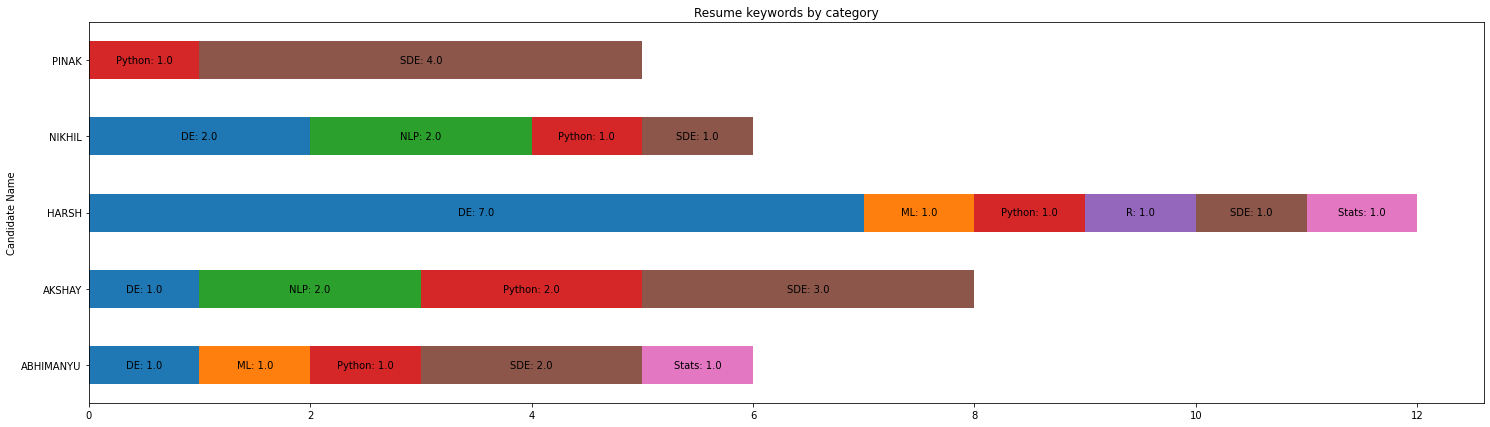

In [789]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 10})
ax = new_data.plot.barh(title="Resume keywords by category", legend=False, figsize=(25,7), stacked=True)
labels = []
for j in new_data.columns:
    for i in new_data.index:
        label = str(j)+": " + str(new_data.loc[i][j])
        labels.append(label)
patches = ax.patches
for label, rect in zip(labels, patches):
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., label, ha='center', va='center')
plt.show()